# Predicting running performance using personal data
# Data analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

In [ ]:
# Load training set
data_train = pd.read_csv("data_train.csv", index_col = 0)

## Exploratory data analysis

In [ ]:
# Data description
data_train.describe()

,y,PredDist,AgePred,PerfTime,PerfDist,DeltaAgePerf,Height,Weight,Gender,Alpha,Beta,IsAlphaBeta
count,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000,93029.000000
mean,4005.725852,14.696698,35.979404,3589.891677,13.361877,1.301347,174.424717,64.461082,0.809404,4.677046,0.998185,0.902375
std,6002.335939,17.574379,10.941665,4933.034458,14.999618,1.034647,9.632501,9.610644,0.392774,1.549797,0.334373,0.296809
min,102.530000,0.800000,18.000000,103.760000,0.800000,-8.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000
25%,492.530000,3.000000,27.000000,485.150000,3.000000,0.000000,170.000000,58.000000,1.000000,5.045602,1.065067,1.000000
50%,2028.000000,10.000000,36.000000,2130.000000,10.000000,1.000000,175.000000,65.000000,1.000000,5.147483,1.091851,1.000000
75%,5079.000000,21.097000,44.000000,4961.000000,21.097000,2.000000,180.000000,70.000000,1.000000,5.253999,1.121753,1.000000
max,70942.000000,100.000000,81.000000,70942.000000,100.000000,3.000000,216.000000,200.000000,1.000000,8.088166,2.080752,1.000000


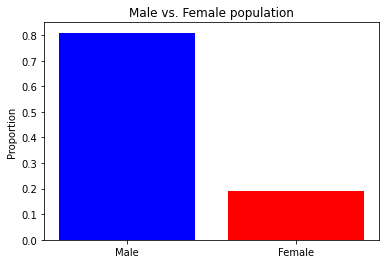

In [ ]:
# Males vs females
plt.bar(x = ["Male", "Female"], height = [data_train.Gender.mean(), 1-data_train.Gender.mean()], color= ["b", "r"])
plt.title("Male vs. Female population")
plt.ylabel("Proportion")
plt.show()

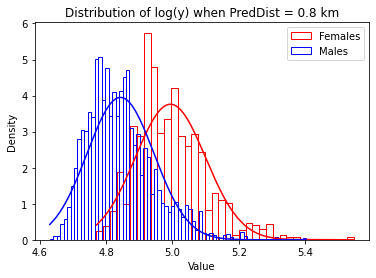

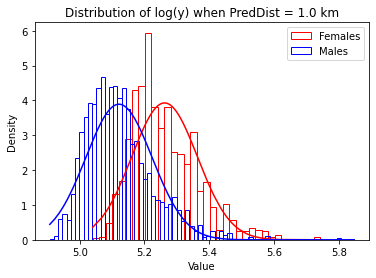

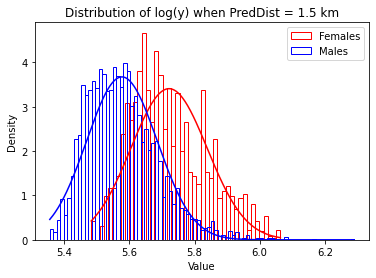

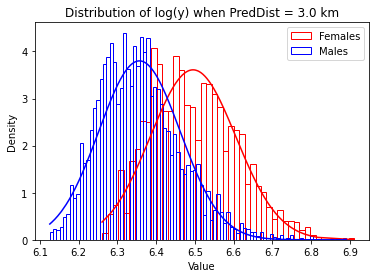

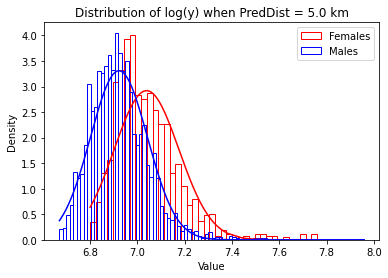

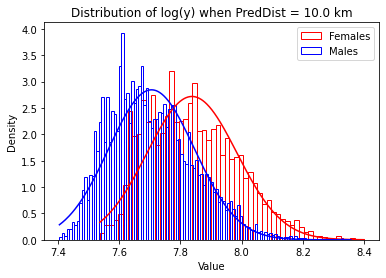

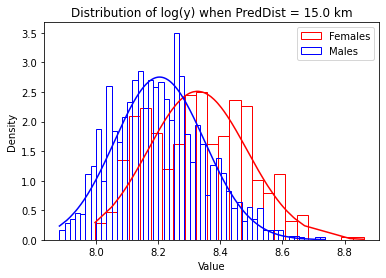

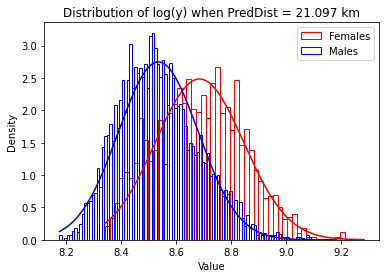

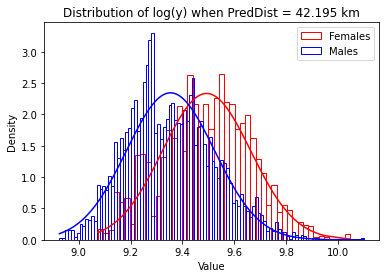

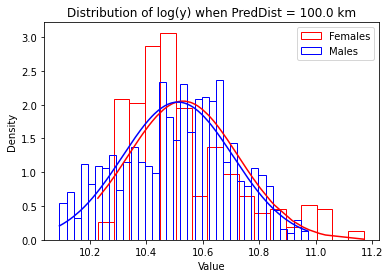

In [ ]:
# y distribution per distance and gender
pred_dist = np.sort(data_train.PredDist.unique())

for dist in pred_dist:
  df_F = data_train[(data_train.PredDist == dist) & (data_train.Gender == 0)]
  plt.hist(np.log(df_F.y), fill = None, edgecolor = "r", bins = round(np.sqrt(df_F.shape[0])), density = True, label = "Females")
  plt.plot(np.sort(np.log(df_F.y.values)), 
           norm.pdf(np.sort(np.log(df_F.y.values)), loc = np.mean(np.log(df_F.y)), scale = np.std(np.log(df_F.y))),
           color = "r")
  df_M = data_train[(data_train.PredDist == dist) & (data_train.Gender == 1)]
  plt.hist(np.log(df_M.y), fill = None, edgecolor = "b", bins = round(np.sqrt(df_M.shape[0])), density = True, label = "Males")
  plt.plot(np.sort(np.log(df_M.y.values)), 
          norm.pdf(np.sort(np.log(df_M.y.values)), loc = np.mean(np.log(df_M.y)), scale = np.std(np.log(df_M.y))),
          color = "b")
  plt.title("Distribution of log(y) when PredDist = " + str(dist) + " km")
  plt.xlabel("Value")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

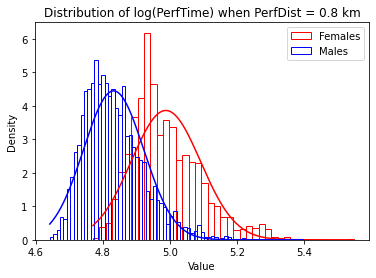

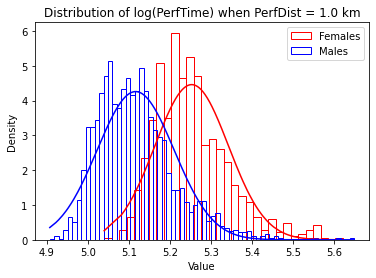

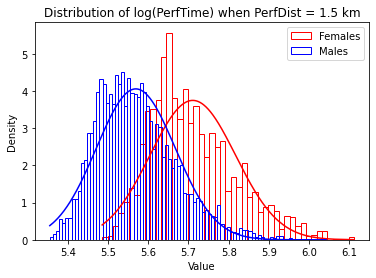

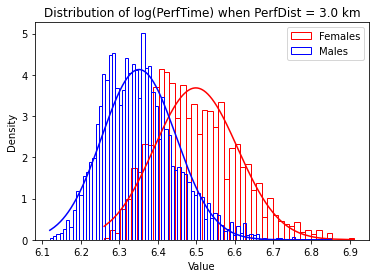

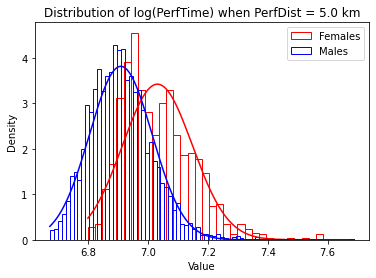

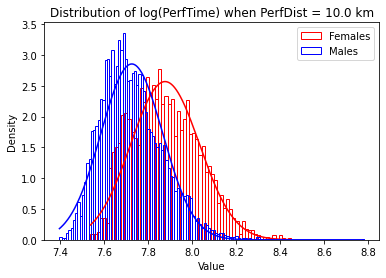

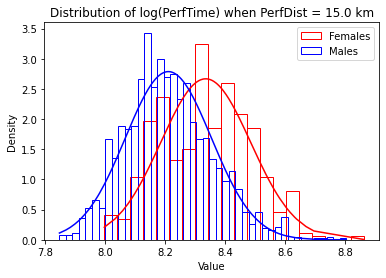

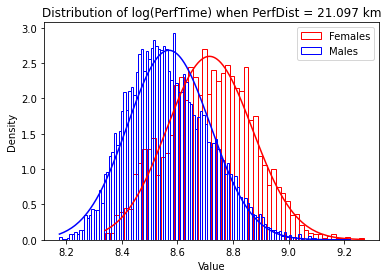

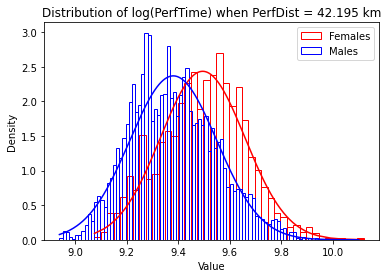

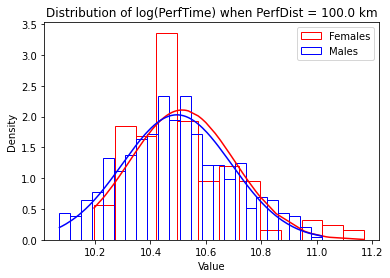

In [ ]:
# PerfTime distribution per distance and gender
pred_dist = np.sort(data_train.PerfDist.unique())

for dist in pred_dist:
  df_F = data_train[(data_train.PerfDist == dist) & (data_train.Gender == 0)]
  plt.hist(np.log(df_F.PerfTime), fill = None, edgecolor = "r", bins = round(np.sqrt(df_F.shape[0])), density = True, label = "Females")
  plt.plot(np.sort(np.log(df_F.PerfTime.values)), 
           norm.pdf(np.sort(np.log(df_F.PerfTime.values)), loc = np.mean(np.log(df_F.PerfTime)), scale = np.std(np.log(df_F.PerfTime))),
           color = "r")
  df_M = data_train[(data_train.PerfDist == dist) & (data_train.Gender == 1)]
  plt.hist(np.log(df_M.PerfTime), fill = None, edgecolor = "b", bins = round(np.sqrt(df_M.shape[0])), density = True, label = "Males")
  plt.plot(np.sort(np.log(df_M.PerfTime.values)), 
          norm.pdf(np.sort(np.log(df_M.PerfTime.values)), loc = np.mean(np.log(df_M.PerfTime)), scale = np.std(np.log(df_M.PerfTime))),
          color = "b")
  plt.title("Distribution of log(PerfTime) when PerfDist = " + str(dist) + " km")
  plt.xlabel("Value")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

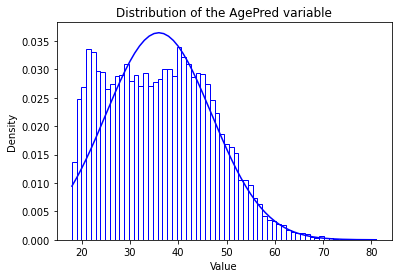

In [ ]:
# AgePred distribution
x = data_train.AgePred
plt.hist(x, fill = None, edgecolor = 'b', bins = len(x.unique()), density = True)
plt.plot(np.sort(x), norm.pdf(np.sort(x), loc = np.mean(x), scale = np.std(x)), color = 'b')
plt.title("Distribution of the AgePred variable")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

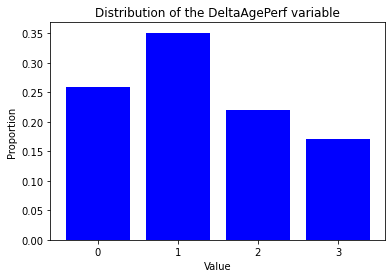

In [ ]:
# DeltaAgePerf distribution
plt.bar(x = ["0", "1", "2", "3"], height = [len(data_train.DeltaAgePerf[data_train.DeltaAgePerf == 0])/data_train.shape[0], 
                                            len(data_train.DeltaAgePerf[data_train.DeltaAgePerf == 1])/data_train.shape[0],
                                            len(data_train.DeltaAgePerf[data_train.DeltaAgePerf == 2])/data_train.shape[0],
                                            len(data_train.DeltaAgePerf[data_train.DeltaAgePerf == 3])/data_train.shape[0]], color = "b")
plt.title("Distribution of the DeltaAgePerf variable")
plt.xlabel("Value")
plt.ylabel("Proportion")
plt.show()

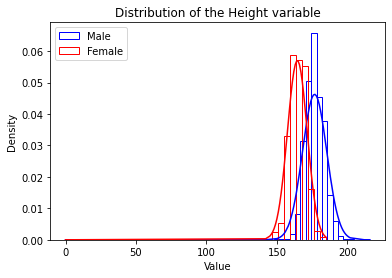

In [ ]:
# Height distribution
x_M = data_train[data_train.Gender == 1].Height
plt.hist(x_M, fill = None, edgecolor = "b", bins = len(x_M.unique()), density = True, label = "Male")
plt.plot(np.sort(x_M), norm.pdf(np.sort(x_M), loc = np.mean(x_M), scale = np.std(x_M)), color = "b")
x_F = data_train[data_train.Gender == 0].Height
plt.hist(x_F, fill = None, edgecolor = "r", bins = len(x_F.unique()), density = True, label = "Female")
plt.plot(np.sort(x_F), norm.pdf(np.sort(x_F), loc = np.mean(x_F), scale = np.std(x_F)), color = "r")
plt.title("Distribution of the Height variable")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

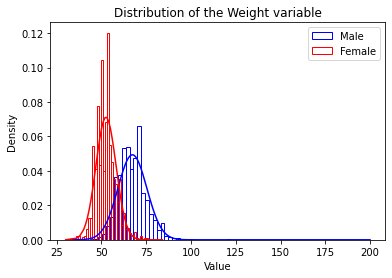

In [ ]:
# Weight distribution
x_M = data_train[data_train.Gender == 1].Weight
plt.hist(x_M, fill = None, edgecolor = "b", bins = len(x_M.unique()), density = True, label = "Male")
plt.plot(np.sort(x_M), norm.pdf(np.sort(x_M), loc = np.mean(x_M), scale = np.std(x_M)), color = "b")
x_F = data_train[data_train.Gender == 0].Weight
plt.hist(x_F, fill = None, edgecolor = "r", bins = len(x_F.unique()), density = True, label = "Female")
plt.plot(np.sort(x_F), norm.pdf(np.sort(x_F), loc = np.mean(x_F), scale = np.std(x_F)), color = "r")
plt.title("Distribution of the Weight variable")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

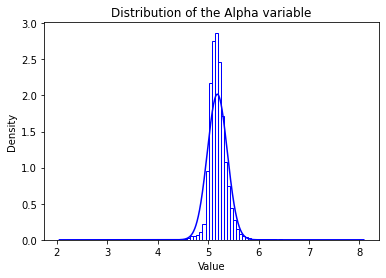

In [ ]:
# Alpha distribution
x = data_train.Alpha[data_train.Alpha > 0]
plt.hist(x, fill = None, edgecolor = "b", bins = 100, density = True)
plt.plot(np.sort(x), norm.pdf(np.sort(x), loc = np.mean(x), scale = np.std(x)), color = 'b')
plt.title("Distribution of the Alpha variable")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

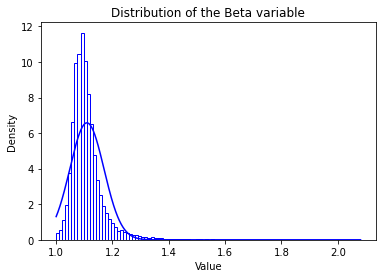

In [ ]:
# Beta distribution
x = data_train.Beta[data_train.Beta > 1]
plt.hist(x, fill = None, edgecolor = "b", bins = 100, density = True)
plt.plot(np.sort(x), norm.pdf(np.sort(x), loc = np.mean(x), scale = np.std(x)), color = 'b')
plt.title("Distribution of the Beta variable")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

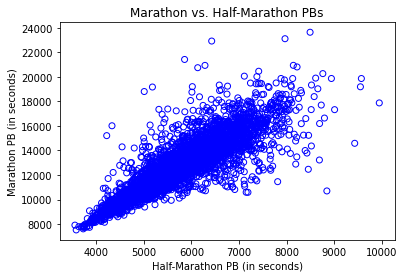

In [ ]:
# Example of correlation between performances on two different distances
df_m_hm = data_train[(data_train.PredDist == 42.195) & (data_train.PerfDist == 21.097)]
m = df_m_hm.y
hm = df_m_hm.PerfTime
plt.scatter(hm, m, color = "b", facecolors = "none")
plt.title("Marathon vs. Half-Marathon PBs")
plt.xlabel("Half-Marathon PB (in seconds)")
plt.ylabel("Marathon PB (in seconds)")
plt.show()

## Removing outliers

In [ ]:
# Store index in first column
data_train.insert(0, "Index", data_train.index)
data_train = data_train.reset_index(drop = True)

In [ ]:
# y outliers
pred_dist = np.sort(data_train.PredDist.unique())
genders = [0,1]

for dist in pred_dist:
  for gender in genders:
    df = data_train[(data_train.PredDist == dist) & (data_train.Gender == gender)]
    scores = norm.cdf(np.log(df.y), loc = np.mean(np.log(df.y)), scale = np.std(np.log(df.y)))
    filt = np.abs(scores - 0.5) >= 0.999/2
    data_train = data_train.iloc[~data_train.index.isin(df.iloc[filt,:].index),:]

In [ ]:
# PerfTime outliers
perf_dist = np.sort(data_train.PerfDist.unique())

for dist in perf_dist:
  for gender in genders:
    df = data_train[(data_train.PerfDist == dist) & (data_train.Gender == gender)]
    scores = norm.cdf(np.log(df.PerfTime), loc = np.mean(np.log(df.PerfTime)), scale = np.std(np.log(df.PerfTime)))
    filt = np.abs(scores - 0.5) >= 0.999/2
    data_train = data_train.iloc[~data_train.index.isin(df.iloc[filt,:].index),:]

In [ ]:
# AgePred outliers
scores = norm.cdf(data_train.AgePred, loc = np.mean(data_train.AgePred), scale = np.std(data_train.AgePred))
filt = np.abs(scores - 0.5) >= 0.999/2
data_train = data_train.iloc[~filt,:]

In [ ]:
# DeltaAgePerf outliers
data_train = data_train[data_train.DeltaAgePerf >= 0]

In [ ]:
# Height outliers
for gender in genders:
  df = data_train[data_train.Gender == gender]
  scores = norm.cdf(df.Height, loc = np.mean(df.Height), scale = np.std(df.Height))
  filt = np.abs(scores - 0.5) >= 0.999/2
  data_train = data_train.iloc[~data_train.index.isin(df.iloc[filt,:].index),:]

In [ ]:
# Weight outliers
for gender in genders:
  df = data_train[data_train.Gender == gender]
  scores = norm.cdf(df.Weight, loc = np.mean(df.Weight), scale = np.std(df.Weight))
  filt = np.abs(scores - 0.5) >= 0.999/2
  data_train = data_train.iloc[~data_train.index.isin(df.iloc[filt,:].index),:]

In [ ]:
# Alpha outliers
df = data_train[data_train.Alpha > 0]
scores = norm.cdf(df.Alpha, loc = np.mean(df.Alpha), scale = np.std(df.Alpha))
filt = np.abs(scores - 0.5) >= 0.999/2
data_train = data_train.iloc[~data_train.index.isin(df.iloc[filt,:].index),:]

In [ ]:
# Beta outliers
df = data_train[data_train.Beta > 0]
scores = norm.cdf(df.Beta, loc = np.mean(df.Beta), scale = np.std(df.Beta))
filt = np.abs(scores - 0.5) >= 0.999/2
data_train = data_train.iloc[~data_train.index.isin(df.iloc[filt,:].index),:]
data_train = data_train[data_train.Beta > 1]

In [ ]:
# In order to enable accurate prediction when alpha and beta are not available create duplicate rows where Alpha = Beta = IsAlphaBeta = 0
data_train = data_train.set_index("Index")
df_dup = data_train[data_train.IsAlphaBeta == 1]
df_dup[["Alpha", "Beta", "IsAlphaBeta"]] = 0
data_train = pd.concat([data_train, df_dup], axis = 0)
data_train = data_train.loc[data_train.index.unique(),:]

In [ ]:
# Save training set with duplicates and without outliers
data_train.to_csv("data_train_dup.csv")

## Model selection

In [ ]:
# Create X and y variables
X = data_train.iloc[:,1:].values
y = data_train.iloc[:,0].values.reshape(-1,1)

In [ ]:
# Use 5-fold cross-validation
folds = 5
folds_index = []
idx_unique = list(data_train.index.unique())
N = len(idx_unique)
df_index = pd.DataFrame({"Index": data_train.index})

for i in range(folds):
  if i < folds:
    idx_val = idx_unique[i*round(N/5):(i+1)*round(N/5)]
  else:
    idx_val = idx_unique[i*round(N/5):]
  start_idx = df_index[df_index.Index == idx_val[0]].index[0]
  end_idx = df_index[df_index.Index == idx_val[-1]].index[-1]
  idx_val = list(range(start_idx, end_idx+1))
  folds_index.append(idx_val)

In [ ]:
# Create absolute percentage error function
def ape(y_true, y_pred):
    return [np.abs((y_true[i]-y_pred[i])/y_true[i]) for i in range(len(y_pred))]

In [ ]:
# Create cross-validation pipeline
def cv_pipeline(X, y, models):    
  res = []
  counter = 0
  print("0/" + str(folds) + " done")

  for val_index in folds_index:    
    # Initialization
    y_train = np.delete(y, val_index, axis = 0)
    X_train = np.delete(X, val_index, axis = 0)
    y_val = y[val_index,:]
    X_val = X[val_index,:]

    # Fitting and scoring
    res_mod = []
    for model in models:
      print("  " + str(model))
      regressor = model
      regressor.fit(X_train, y_train)
      y_pred = regressor.predict(X_val)
      res_mod.append(ape(y_val.flatten(), y_pred.flatten()))
    
    res.append(res_mod)
      
    # Count iterations
    counter += 1
    print(str(counter) + "/" + str(folds) + " done")

  return res

In [ ]:
# Create performance summary function
def perf_sum(res, models):
    df = pd.DataFrame(index = models, columns = ["MAPE-Avg", "MAPE-Std", "MedAPE-Avg", "MedAPE-Std"])
    
    for i in range(len(models)):
        x_mean = [np.mean(y[i]) for y in res]
        x_med = [np.median(y[i]) for y in res]
        df.iloc[i,:] = [np.mean(x_mean), np.std(x_mean), np.mean(x_med), np.std(x_med)]
    
    return df

In [ ]:
# Initialize summary table
summary = pd.DataFrame()

### Linear regression

In [ ]:
# Convert PredDist and PerfDist to dummy variables
data_train_dum = pd.get_dummies(data_train, columns = ["PredDist", "PerfDist"])
X_dum = data_train_dum.iloc[:,1:].values

#### Using basic data set

In [ ]:
# Cross-validation
linreg = cv_pipeline(X_dum, y, [LinearRegression()])

0/5 done
  LinearRegression()
1/5 done
  LinearRegression()
2/5 done
  LinearRegression()
3/5 done
  LinearRegression()
4/5 done
  LinearRegression()
5/5 done


In [ ]:
# Results
linreg_sum = perf_sum(linreg, ["Linear regression (basic data set)"])
summary = pd.concat([summary, linreg_sum], axis = 0).drop_duplicates()
linreg_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Linear regression (basic data set),0.543563,0.016436,0.149385,0.001511


#### Using transformed data set

In [ ]:
# Transform X and y variables to minimize the relevant cost function
X_mod = np.concatenate((1/y, X_dum/y), axis = 1)
y_mod = np.ones((len(y), 1))

In [ ]:
# Cross-validation
linreg_mod = cv_pipeline(X_mod, y_mod, [LinearRegression(fit_intercept = False)])

0/5 done
  LinearRegression(fit_intercept=False)
1/5 done
  LinearRegression(fit_intercept=False)
2/5 done
  LinearRegression(fit_intercept=False)
3/5 done
  LinearRegression(fit_intercept=False)
4/5 done
  LinearRegression(fit_intercept=False)
5/5 done


In [ ]:
# Results
linreg_mod_sum = perf_sum(linreg_mod, ["Linear regression (modified data set)"])
summary = pd.concat([summary, linreg_mod_sum], axis = 0).drop_duplicates()
linreg_mod_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Linear regression (modified data set),0.089764,0.000653,0.07035,0.001166


#### Using interaction terms

In [ ]:
# Create interaction terms
poly = PolynomialFeatures(degree = 2)
X_int = poly.fit_transform(X_dum)
X_int_mod = X_int/y

In [ ]:
# Cross-validation
linreg_int = cv_pipeline(X_int_mod, y_mod, [LinearRegression(fit_intercept = False)])

0/5 done
  LinearRegression(fit_intercept=False)
1/5 done
  LinearRegression(fit_intercept=False)
2/5 done
  LinearRegression(fit_intercept=False)
3/5 done
  LinearRegression(fit_intercept=False)
4/5 done
  LinearRegression(fit_intercept=False)
5/5 done


In [ ]:
# Results
linreg_int_sum = perf_sum(linreg_int, ["Linear regression (with interaction terms)"])
summary = pd.concat([summary, linreg_int_sum], axis = 0).drop_duplicates()
linreg_int_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Linear regression (with interaction terms),0.050987,0.000504,0.036655,0.000749


### K nearest neighbors

In [ ]:
# Create scaled data set
sc = StandardScaler()
X_sc = sc.fit_transform(X_dum) 

In [ ]:
# Cross-validation
knnreg = cv_pipeline(X_sc, y, [KNeighborsRegressor(n_neighbors = 1),
                               KNeighborsRegressor(n_neighbors = 5),
                               KNeighborsRegressor(n_neighbors = 10)])

0/5 done
  KNeighborsRegressor(n_neighbors=1)
  KNeighborsRegressor()
  KNeighborsRegressor(n_neighbors=10)
1/5 done
  KNeighborsRegressor(n_neighbors=1)
  KNeighborsRegressor()
  KNeighborsRegressor(n_neighbors=10)
2/5 done
  KNeighborsRegressor(n_neighbors=1)
  KNeighborsRegressor()
  KNeighborsRegressor(n_neighbors=10)
3/5 done
  KNeighborsRegressor(n_neighbors=1)
  KNeighborsRegressor()
  KNeighborsRegressor(n_neighbors=10)
4/5 done
  KNeighborsRegressor(n_neighbors=1)
  KNeighborsRegressor()
  KNeighborsRegressor(n_neighbors=10)
5/5 done


In [ ]:
# Results
knnreg_sum = perf_sum(knnreg, ["KNN (neighbors = " + str(k) + ")" for k in [1,5,10]])
summary = pd.concat([summary, knnreg_sum], axis = 0).drop_duplicates()
knnreg_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
KNN (neighbors = 1),0.089445,0.000752,0.070108,0.000626
KNN (neighbors = 5),0.072581,0.001108,0.057309,0.000353
KNN (neighbors = 10),0.071766,0.001333,0.056026,0.000671


### Decision tree

In [ ]:
# Cross-validation
treereg = cv_pipeline(X, y, [DecisionTreeRegressor(min_samples_leaf = 1),
                             DecisionTreeRegressor(min_samples_leaf = 0.0001),
                             DecisionTreeRegressor(min_samples_leaf = 0.001),
                             DecisionTreeRegressor(min_samples_leaf = 0.01)])

0/5 done
  DecisionTreeRegressor()
  DecisionTreeRegressor(min_samples_leaf=0.0001)
  DecisionTreeRegressor(min_samples_leaf=0.001)
  DecisionTreeRegressor(min_samples_leaf=0.01)
1/5 done
  DecisionTreeRegressor()
  DecisionTreeRegressor(min_samples_leaf=0.0001)
  DecisionTreeRegressor(min_samples_leaf=0.001)
  DecisionTreeRegressor(min_samples_leaf=0.01)
2/5 done
  DecisionTreeRegressor()
  DecisionTreeRegressor(min_samples_leaf=0.0001)
  DecisionTreeRegressor(min_samples_leaf=0.001)
  DecisionTreeRegressor(min_samples_leaf=0.01)
3/5 done
  DecisionTreeRegressor()
  DecisionTreeRegressor(min_samples_leaf=0.0001)
  DecisionTreeRegressor(min_samples_leaf=0.001)
  DecisionTreeRegressor(min_samples_leaf=0.01)
4/5 done
  DecisionTreeRegressor()
  DecisionTreeRegressor(min_samples_leaf=0.0001)
  DecisionTreeRegressor(min_samples_leaf=0.001)
  DecisionTreeRegressor(min_samples_leaf=0.01)
5/5 done


In [ ]:
# Results
treereg_sum  = perf_sum(treereg, ["Decision tree (min_samples_leaf = " + str(k) + ")" for k in [None, 0.0001, 0.001, 0.01]])
summary = pd.concat([summary, treereg_sum], axis = 0).drop_duplicates()
treereg_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Decision tree (min_samples_leaf = None),0.060699,0.000593,0.040331,0.00075
Decision tree (min_samples_leaf = 0.0001),0.049821,0.000962,0.033935,0.0007
Decision tree (min_samples_leaf = 0.001),0.0542,0.00077,0.038874,0.00073
Decision tree (min_samples_leaf = 0.01),0.07456,0.000823,0.058832,0.001309


### Random forest regression

In [ ]:
# Cross-validation
rfreg = cv_pipeline(X, y, [RandomForestRegressor(n_estimators = 100, random_state = 0)])

0/5 done
  RandomForestRegressor(random_state=0)
1/5 done
  RandomForestRegressor(random_state=0)
2/5 done
  RandomForestRegressor(random_state=0)
3/5 done
  RandomForestRegressor(random_state=0)
4/5 done
  RandomForestRegressor(random_state=0)
5/5 done


In [ ]:
# Results
rfreg_sum = perf_sum(rfreg, ["Random forest (n_estimators = 100)"])
summary = pd.concat([summary, rfreg_sum], axis = 0).drop_duplicates()
rfreg_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Random forest (n_estimators = 100),0.043928,0.000444,0.030209,0.000313


### XGBoost regression

In [ ]:
# Cross-validation
xgbreg = cv_pipeline(X, y, [XGBRegressor(objective = "reg:squarederror")])

0/5 done
  XGBRegressor(eta=0.01, objective='reg:squarederror')
1/5 done
  XGBRegressor(eta=0.01, objective='reg:squarederror')
2/5 done
  XGBRegressor(eta=0.01, objective='reg:squarederror')
3/5 done
  XGBRegressor(eta=0.01, objective='reg:squarederror')
4/5 done
  XGBRegressor(eta=0.01, objective='reg:squarederror')
5/5 done


In [ ]:
# Results
xgbreg_sum = perf_sum(xgbreg, ["XGB Regressor (learning rate = 0.3)"])
summary = pd.concat([summary, xgbreg_sum], axis = 0).drop_duplicates()
xgbreg_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
XGB Regressor (learning rate = 0.3),0.1738,0.003021,0.082085,0.00221


### Neural network

#### One hidden layer with 6 nodes

In [ ]:
# Cross-validation
nnetreg = []
counter = 0
earlystopping = keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 5, restore_best_weights = True)
print("0/" + str(folds) + " done")

for val_index in folds_index:    
  # Initialization
  y_train = np.delete(y, val_index, axis = 0)
  X_train = np.delete(X_sc, val_index, axis = 0)
  y_val = y[val_index,:]
  X_val = X_sc[val_index,:]

  # Create model model and add layers 
  ann = keras.models.Sequential()
  ann.add(keras.layers.Dense(units = 20, activation = "relu"))
  ann.add(keras.layers.Dense(units = 1))

  # Fitting and scoring
  res_mod = []
  ann.compile(optimizer = "adam", loss = "mean_absolute_percentage_error")
  ann.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [earlystopping])
  y_pred = ann.predict(X_val)
  res_mod.append(ape(y_val, y_pred))
  nnetreg.append(res_mod)
    
  # Count iterations
  counter += 1
  print(str(counter) + "/" + str(folds) + " done")

0/5 done
Epoch 1/100
4014/4014 [==============================] - 8s 2ms/step - loss: 75.4402 - val_loss: 59.9525
Epoch 2/100
4014/4014 [==============================] - 7s 2ms/step - loss: 54.8488 - val_loss: 50.0095
Epoch 3/100
4014/4014 [==============================] - 7s 2ms/step - loss: 47.4969 - val_loss: 44.1936
Epoch 4/100
4014/4014 [==============================] - 7s 2ms/step - loss: 40.2936 - val_loss: 38.1006
Epoch 5/100
4014/4014 [==============================] - 7s 2ms/step - loss: 37.7150 - val_loss: 37.3220
Epoch 6/100
4014/4014 [==============================] - 7s 2ms/step - loss: 36.8149 - val_loss: 36.1396
Epoch 7/100
4014/4014 [==============================] - 7s 2ms/step - loss: 35.0781 - val_loss: 33.5975
Epoch 8/100
4014/4014 [==============================] - 7s 2ms/step - loss: 32.0116 - val_loss: 29.7418
Epoch 9/100
4014/4014 [==============================] - 7s 2ms/step - loss: 27.7658 - val_loss: 24.9932
Epoch 10/100
4014/4014 [======================

In [ ]:
# Results
nnetreg_sum = perf_sum(nnetreg, ["Neural network (1x20-node HL)"])
summary = pd.concat([summary, nnetreg_sum], axis = 0).drop_duplicates()
nnetreg_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Neural network (1x20-node HL),0.073821,0.006575,0.043978,0.000588


#### Two hidden layers with 3 nodes each

In [ ]:
# Cross-validation
nnetreg_2hl = []
counter = 0
earlystopping = keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 5, restore_best_weights = True)
print("0/" + str(folds) + " done")

for val_index in folds_index:    
  # Initialization
  y_train = np.delete(y, val_index, axis = 0)
  X_train = np.delete(X_sc, val_index, axis = 0)
  y_val = y[val_index,:]
  X_val = X_sc[val_index,:]

  # Create model model and add layers 
  ann = keras.models.Sequential()
  ann.add(keras.layers.Dense(units = 10, activation = "relu"))
  ann.add(keras.layers.Dense(units = 10, activation = "relu"))
  ann.add(keras.layers.Dense(units = 1))

  # Fitting and scoring
  res_mod = []
  ann.compile(optimizer = "adam", loss = "mean_absolute_percentage_error")
  ann.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [earlystopping])
  y_pred = ann.predict(X_val)
  res_mod.append(ape(y_val, y_pred))
  nnetreg_2hl.append(res_mod)
    
  # Count iterations
  counter += 1
  print(str(counter) + "/" + str(folds) + " done")

0/5 done
Epoch 1/100
4014/4014 [==============================] - 8s 2ms/step - loss: 61.1931 - val_loss: 47.6383
Epoch 2/100
4014/4014 [==============================] - 8s 2ms/step - loss: 35.8428 - val_loss: 28.6781
Epoch 3/100
4014/4014 [==============================] - 7s 2ms/step - loss: 23.9523 - val_loss: 21.0392
Epoch 4/100
4014/4014 [==============================] - 8s 2ms/step - loss: 21.5666 - val_loss: 20.6545
Epoch 5/100
4014/4014 [==============================] - 8s 2ms/step - loss: 21.2405 - val_loss: 20.3179
Epoch 6/100
4014/4014 [==============================] - 7s 2ms/step - loss: 20.7392 - val_loss: 19.6100
Epoch 7/100
4014/4014 [==============================] - 8s 2ms/step - loss: 19.6848 - val_loss: 18.2298
Epoch 8/100
4014/4014 [==============================] - 8s 2ms/step - loss: 17.5510 - val_loss: 15.1363
Epoch 9/100
4014/4014 [==============================] - 8s 2ms/step - loss: 11.8766 - val_loss: 8.3467
Epoch 10/100
4014/4014 [=======================

In [ ]:
# Results
nnetreg_2hl_sum = perf_sum(nnetreg_2hl, ["Neural network (2x10-node HL)"])
summary = pd.concat([summary, nnetreg_2hl_sum], axis = 0).drop_duplicates()
nnetreg_2hl_sum

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Neural network (2x10-node HL),0.058582,0.004875,0.041558,0.002701


### Summary

In [ ]:
# Print summary
summary

,MAPE-Avg,MAPE-Std,MedAPE-Avg,MedAPE-Std
Linear regression (basic data set),0.543563,0.016436,0.149385,0.001511
Linear regression (modified data set),0.089764,0.000653,0.07035,0.001166
Linear regression (with interaction terms),0.050987,0.000504,0.036655,0.000749
KNN (neighbors = 1),0.089445,0.000752,0.070108,0.000626
KNN (neighbors = 5),0.072581,0.001108,0.057309,0.000353
KNN (neighbors = 10),0.071766,0.001333,0.056026,0.000671
Decision tree (min_samples_leaf = None),0.060699,0.000593,0.040331,0.00075
Decision tree (min_samples_leaf = 0.0001),0.049821,0.000962,0.033935,0.0007
Decision tree (min_samples_leaf = 0.001),0.0542,0.00077,0.038874,0.00073
Decision tree (min_samples_leaf = 0.01),0.07456,0.000823,0.058832,0.001309


In [ ]:
# Save summary
summary.to_csv("summary.csv")